In [16]:
import pymaster as nmt
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pyccl as ccl
import numpy as np
import healpy as hp
import astropy.io.fits as fits
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

#-------------
#input parameters
h = 0.67556
Omega_c=0.26377065934278865
Omega_b=0.0482754208891869
ns = 0.9667
redshift = 0.9
sigma8=0.8225
default_As = 2e-9
#-------------
H0 = h*100
ombh2 = Omega_b*h*h
omch2 = Omega_c*h*h

zs = np.linspace(0.1,1.5,500)
sigma = 0.15
dndz = np.exp(-(zs-0.8)**2/sigma**2)
f_dndz = IUS(zs, dndz/dndz.sum(), ext = 1)
zs_spline = np.linspace(zs.min(),zs.max(),800)
dndz_spline = f_dndz(zs_spline)

In [17]:
#NOTE: this dust map is also publicly available on zenodo. Check this paper for more info: https://arxiv.org/pdf/2409.05140

nside = 256
fn = "/global/cfs/cdirs/desi/users/huikong/truth_input/dust_maps/desi/desi_dust_gr_%d.fits"%nside
dat = fits.getdata(fn)
dat = dat[(dat['EBV_SFD']<0.1)&(dat['EBV_SFD']>0.0)&(dat['EBV_SFD']-dat['EBV_GR']>-0.05)&(dat['EBV_SFD']-dat['EBV_GR']<0.05)]
mean = (dat['EBV_SFD']-dat['EBV_GR']).mean()
debvs = np.zeros(12*256**2)
mask = np.ones(12*256**2)

for i in range(len(dat)):
    iid = dat['HPXPIXEL'][i]
    debvs[iid] = dat['EBV_SFD'][i]-dat['EBV_GR'][i]-mean
mask[debvs == 0] = 0

In [18]:
def get_cell(mnu = 0):
    cosmo_A = ccl.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, h=h, n_s=ns,\
            A_s=default_As, transfer_function = "boltzmann_camb", m_nu=mnu)
    omega_m_A = cosmo_A['Omega_m']
    cosmo_B = ccl.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, h=h, n_s=ns,\
                          A_s=default_As, transfer_function = "boltzmann_camb", m_nu=0)
    omega_m_B = cosmo_B['Omega_m']
    dm = omega_m_A-omega_m_B
    
    cosmo = ccl.Cosmology(Omega_c=Omega_c-dm, Omega_b=Omega_b, h=h, n_s=ns,\
                          A_s=default_As, transfer_function = "boltzmann_camb", m_nu=mnu)
    

    bias = 1.0/cosmo.growth_factor(1/(1+zs_spline))
    gals = ccl.NumberCountsTracer(cosmo, has_rsd=True, dndz=(zs_spline, dndz_spline),
                                  bias=(zs_spline, bias))
    ells = np.arange(1000)
    c_ells = ccl.angular_cl(cosmo, gals, gals, ells)
    return c_ells 

In [19]:
cell_nu0 = get_cell(mnu = 0)
cell_nu01 = get_cell(mnu = 0.07)

In [20]:
mp = np.ones(12*256**2)
f = nmt.NmtField(mask, [mp], n_iter=0)
delta_ell = 30
b = nmt.NmtBin.from_nside_linear(256, nlb=delta_ell)


In [21]:
T = nmt.workspaces.NmtWorkspace()

In [22]:
T.compute_coupling_matrix(f,f,b)
mcn = T.get_coupling_matrix()

In [23]:
C_ell_coupled0 = np.dot(mcn, cell_nu0[:768])
C_ell_coupled01 = np.dot(mcn, cell_nu01[:768])

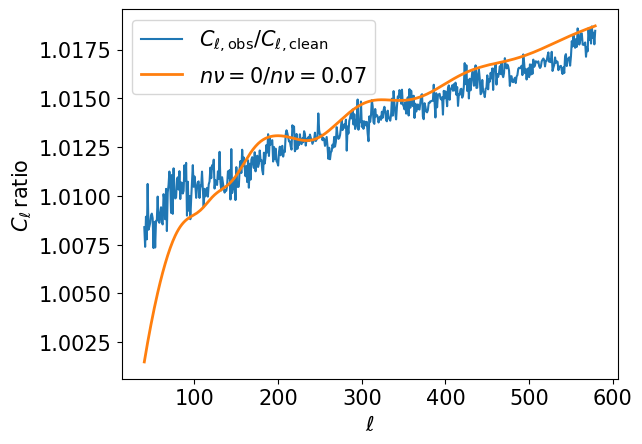

In [24]:
dat = np.loadtxt("../data/bias_ratios_bias.txt")
#plt.errorbar(np.arange(len(dat[0]))[5:580],dat[1][5:580], dat[2][5:580]/np.sqrt(5000),label = r'$C_{\ell, obs} / C_{\ell, homogeneous}$')

plt.plot(np.arange(len(dat[0]))[40:580],dat[3][40:580]/dat[4][40:580], label = r'$C_{\ell, \mathrm{obs}} / C_{\ell, \mathrm{clean}}$')
plt.plot(np.arange(768)[40:580], C_ell_coupled0[40:580]/C_ell_coupled01[40:580]/1.02, label = r'$n\nu=0 / n\nu=0.07$', linewidth=2)


plt.xlabel(r'$\ell$',size = 15)
plt.ylabel(r'$C_\ell\, \mathrm{ratio}$',size = 15)
p=plt.xticks(size = 15)
p=plt.yticks(size = 15)
plt.legend(fontsize = 15)